# Distance between non-African and African haplotypes

Load global analysis variables:

In [1]:
%run standard.py

In [2]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy
import numpy as np
import pandas
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Plotting setup:

In [3]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D 
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Ignore deprecation warnings from mainly seaborn:

In [4]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [5]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [6]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [7]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [8]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

def bootstrap_se(sr, n=10000):
    means = list()
    for i in range(n):
        means.append(numpy.mean(sr.sample(frac=1, replace=True)))
    return numpy.std(means)

## Load meta data

In [9]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load data for each individual

In [10]:
sweep_data = (pandas.read_hdf(results_dir / f'sweep_data_{ech_calling_tag}.hdf')
              .loc[lambda df: df.not_missing == True] # only include windows where enough individuals are called
             )

## Load pairwise distance data

In [11]:
all_male_dist_twice = pandas.read_hdf(steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb_twice.hdf')

## Synthetic ech and non-ech haplotype

In [12]:
df_list = []
for _ in range(100):
    # Get windows where ECHs are called:
    ech_regions = (sweep_data
                   .loc[sweep_data.region_1 != 'Africa']
                   .groupby('start')
                   .filter(lambda df: df.swept_af.sum() > 0)
                  )

    # Sample one ECH and one non-ECH from each genomic window:
    sampled_wins = ech_regions.groupby(['start', 'swept_af']).sample(1)

    dist_sampled_wins = (sampled_wins[['indiv_1', 'start', 'swept_af']]
                         .merge(all_male_dist_twice[['indiv_1', 'indiv_2', 'start', 'dist_af',
                                                     'pop_1', 'pop_2', 'region_1', 'region_2']], 
                                on=['indiv_1', 'start'], how='left')
                        )   

    _df = (dist_sampled_wins
          .loc[lambda df: df.region_2 == 'Africa']
          .groupby(['swept_af', 'indiv_2'], observed=True)
          .dist_af
          .mean()
          .unstack('swept_af')
          .rename_axis(None, axis="columns")
          .reset_index()
          .rename(columns={False: 'non_ech_dist', True: 'ech_dist'})
         )

    df_list.append(_df)
    
df = pd.concat(df_list)

In [19]:
df['indiv_2'] = df.indiv_2.astype('str')

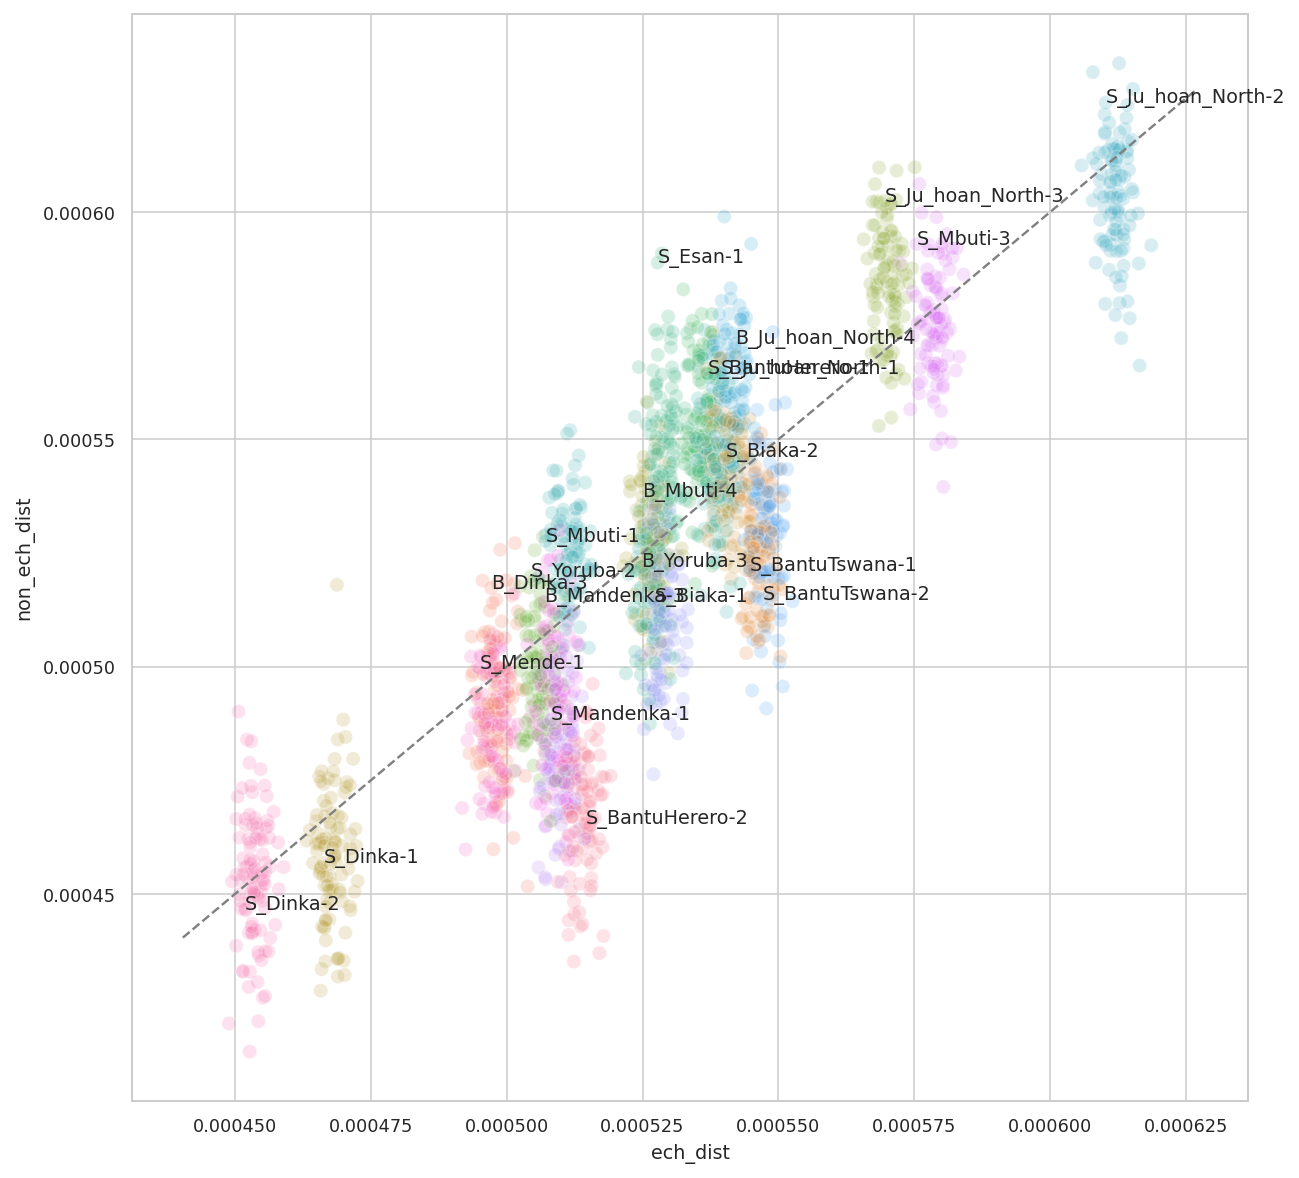

In [20]:
def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=df, x='ech_dist', y='non_ech_dist', hue='indiv_2', alpha=0.2, s=50, legend=False)

for t, x, y in zip(_df.indiv_2, _df.ech_dist, _df.non_ech_dist):
    ax.text(x, y, t)
abline(1, 0)

In [29]:
means_df = df.groupby('indiv_2').mean().reset_index()

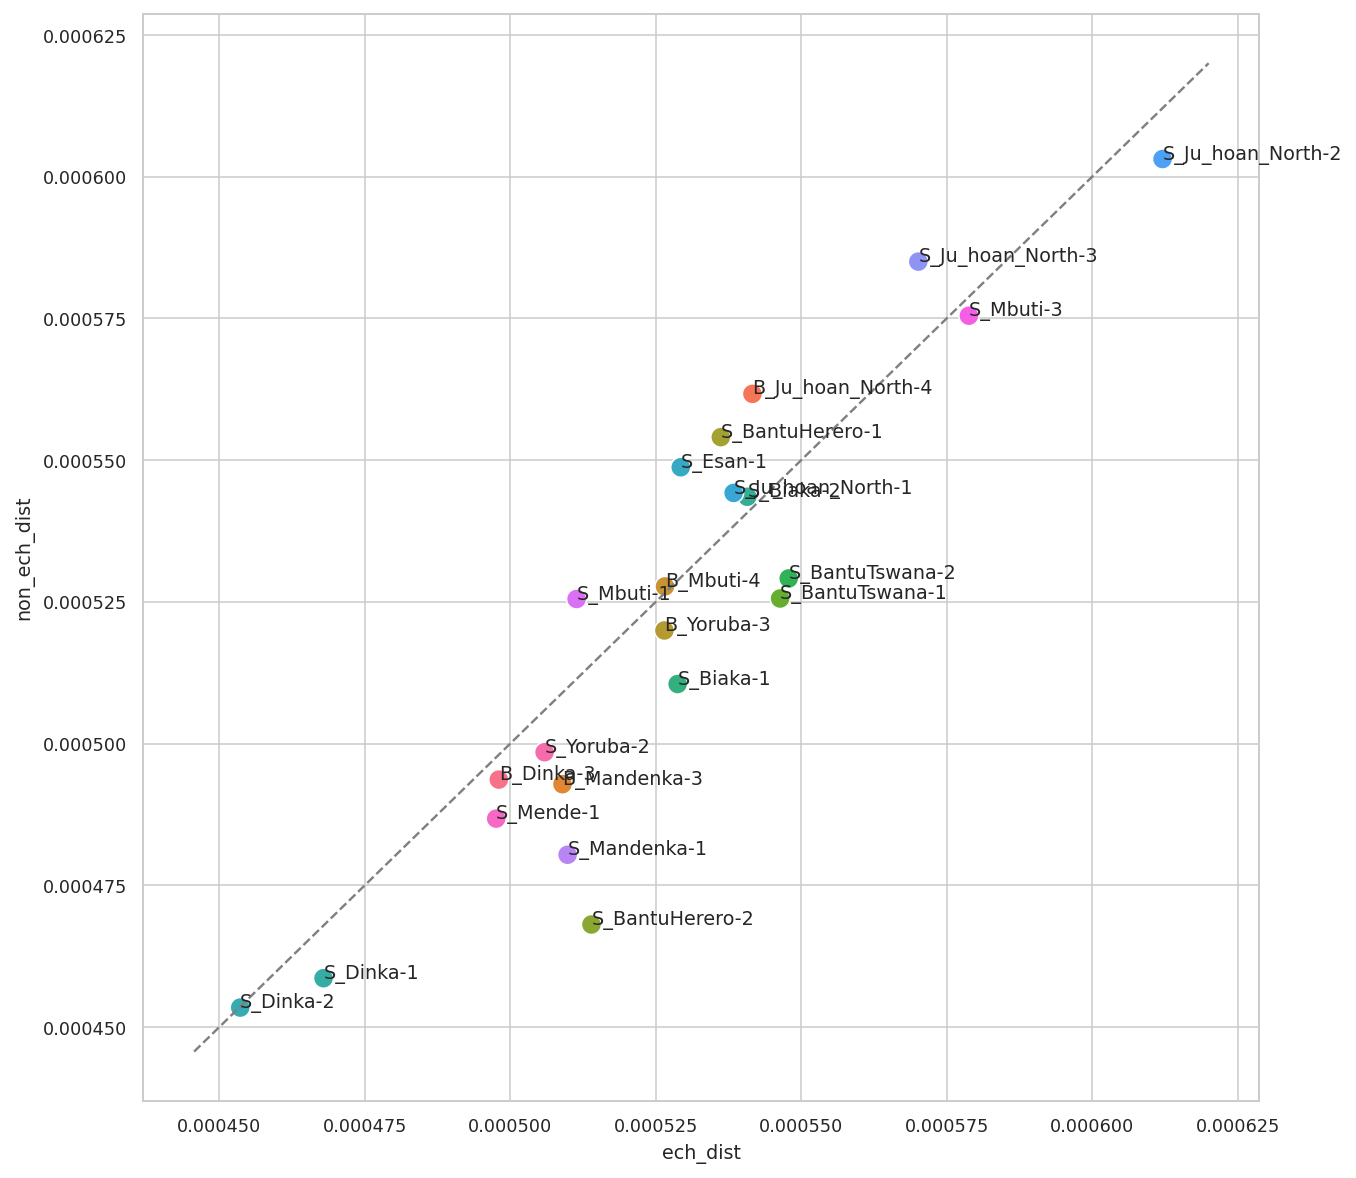

In [32]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=means_df, x='ech_dist', y='non_ech_dist', hue='indiv_2', s=100, legend=False)

for t, x, y in zip(means_df.indiv_2, means_df.ech_dist, means_df.non_ech_dist):
    ax.text(x, y, t)
abline(1, 0)

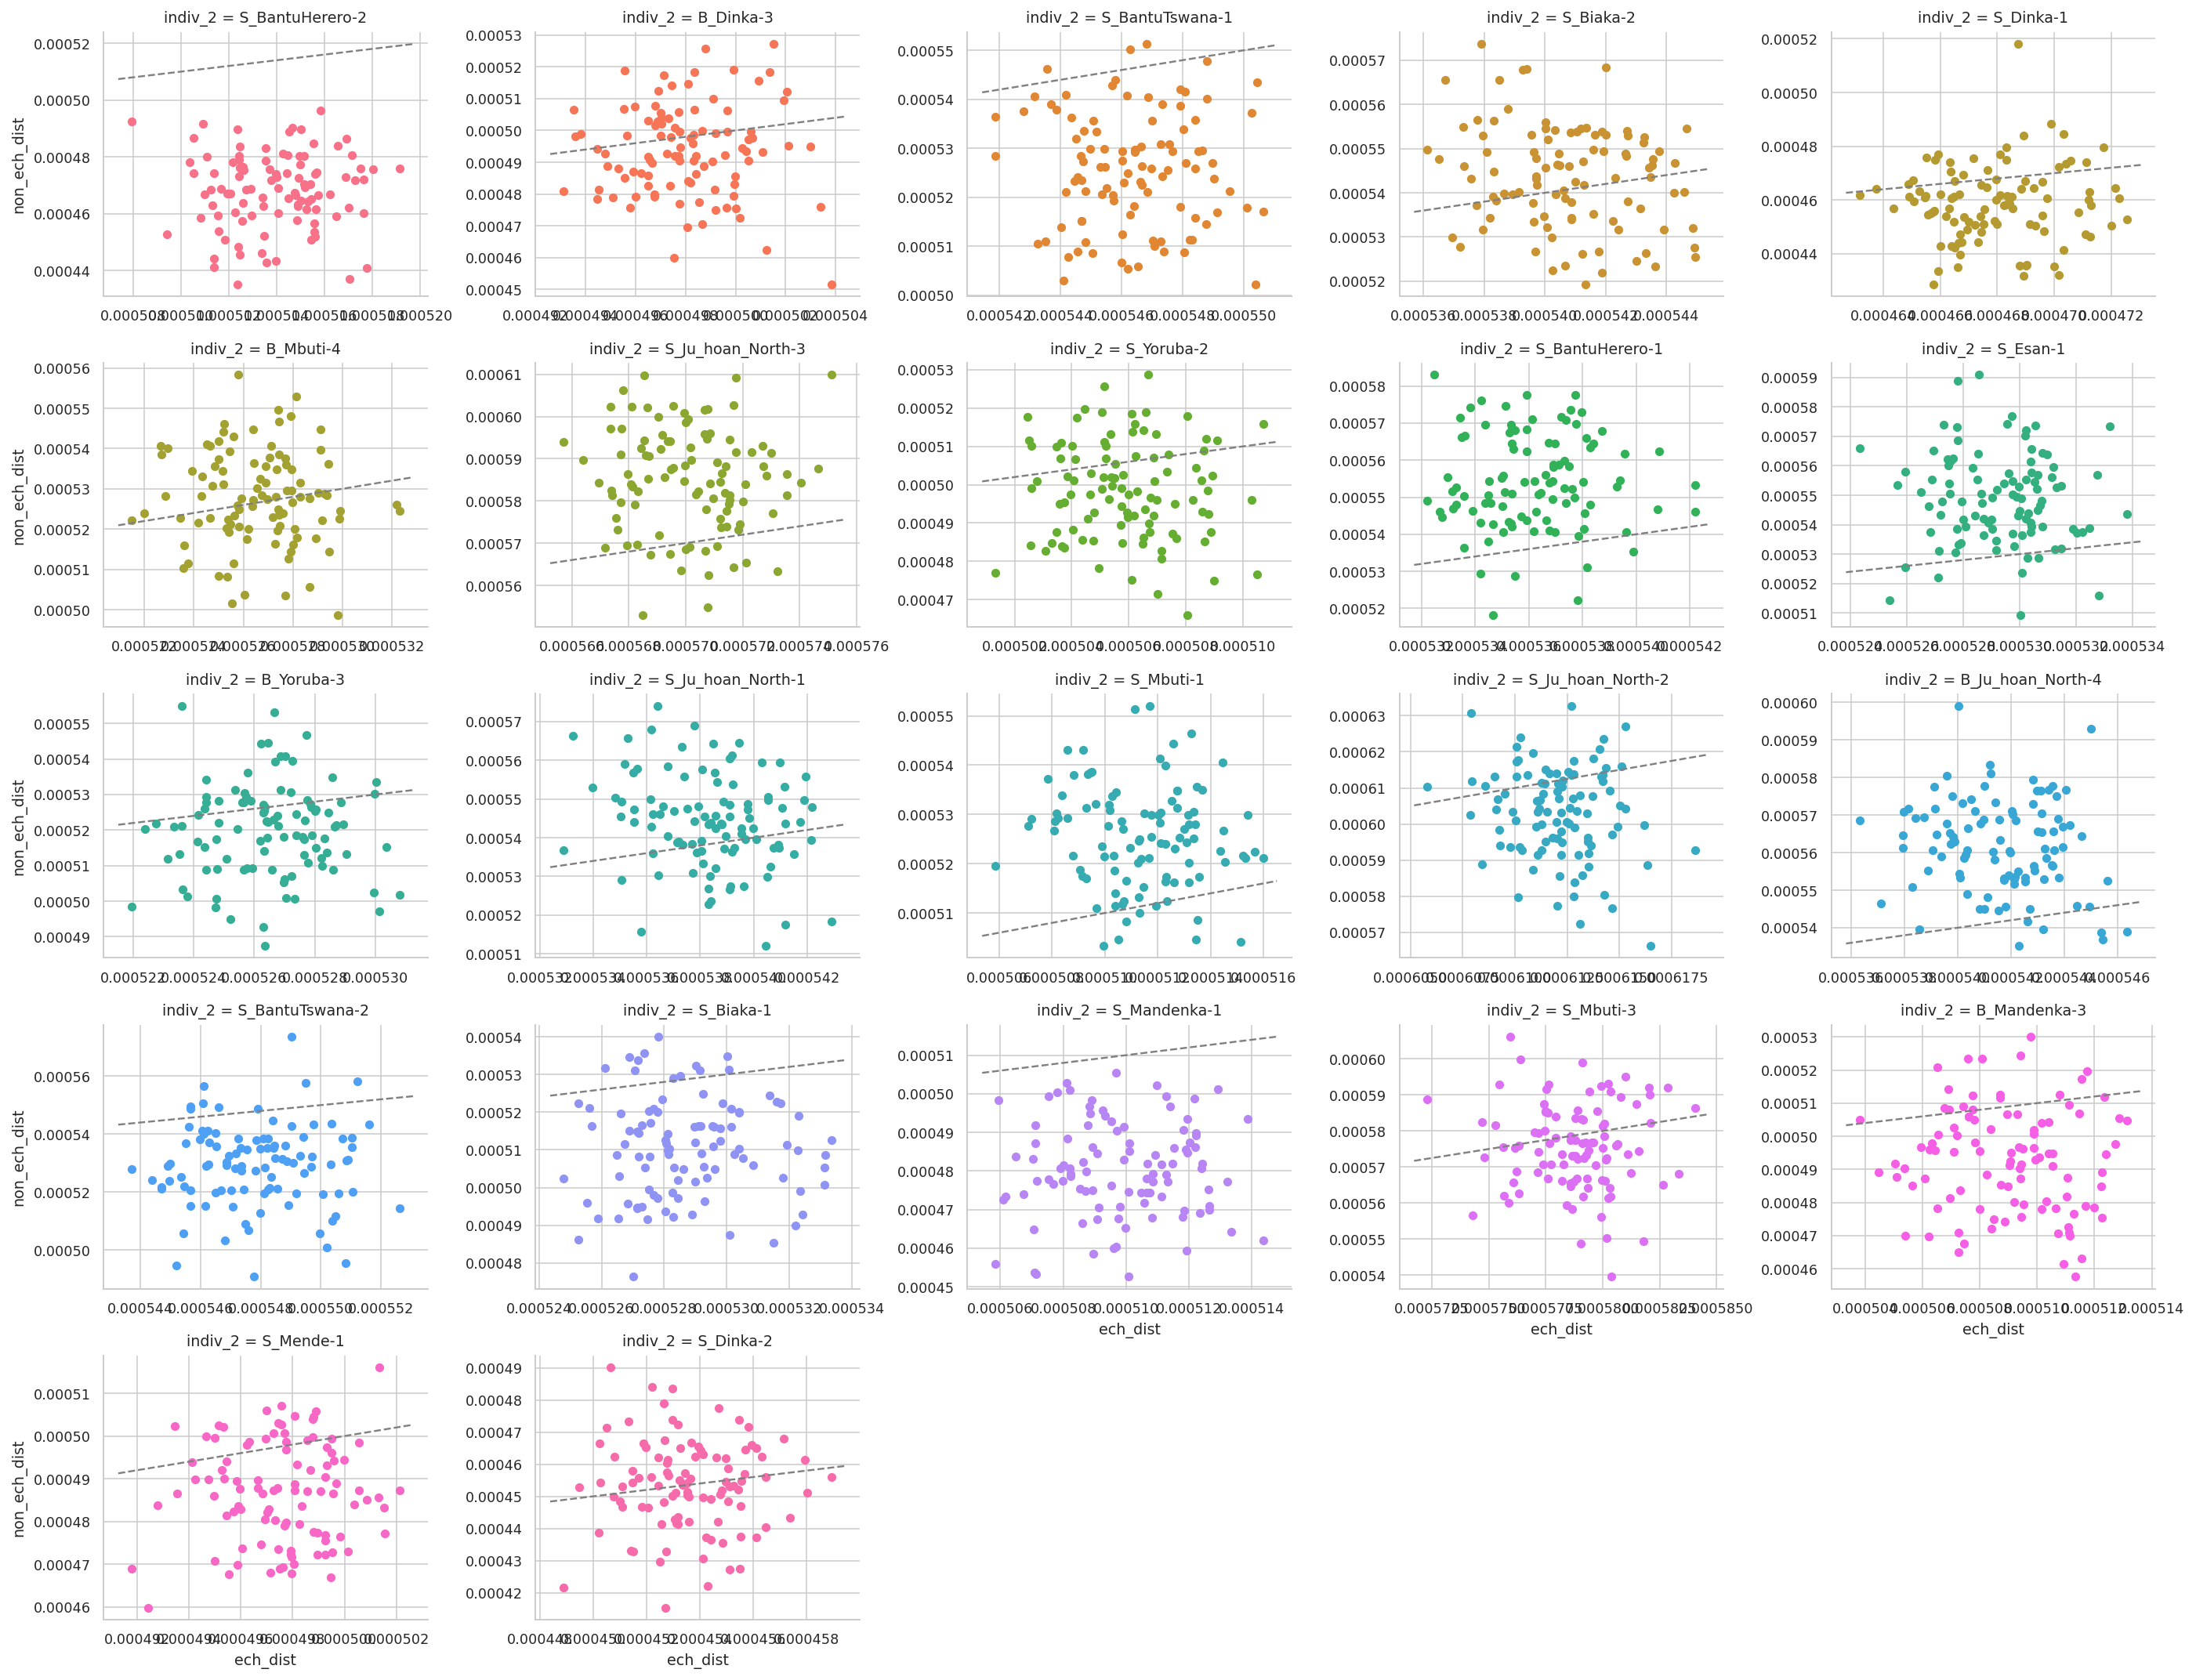

In [33]:
g = sns.FacetGrid(df, col="indiv_2", col_wrap=5, margin_titles=True, sharex=False, sharey=False, aspect=1.3)
g = g.map(plt.scatter, "ech_dist", "non_ech_dist")
for ax in g.axes.flat:
    abline(1, 0, ax=ax)

---

# Old analysis below:

---

## Prepare data

In [15]:
# # pwdiff_store = pandas.HDFStore(str(results_dir / 'all_male_dist_twice.hdf'))
# pwdiff_store = pandas.HDFStore(str(steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.hdf'))

In [ ]:
# nonafr_afr_subset = pwdiff_store.select('df', '(region_label_1 != "Africa") & (region_label_2 == "Africa")')
# nonafr_afr_subset.head()

In [20]:
df = pandas.read_hdf(str(steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.hdf'))
nonafr_afr_subset = df.loc[(df.region_label_1 != "Africa") & (df.region_label_2 == "Africa")]

In [21]:
nonafr_afr_subset.groupby('region_1')['indiv_1'].describe()

,count,unique,top,freq
region_1,,,,
Africa,0,0,NaN,NaN
WestEurasia,1638912,48,S_Jordanian-2,34144
SouthAsia,1058464,31,S_Brahui-1,34144
CentralAsiaSiberia,341440,10,S_Eskimo_Sireniki-1,34144
Oceania,546304,16,B_Australian-4,34144
EastAsia,921888,27,S_Ami-1,34144
America,273152,8,S_Zapotec-2,34144


Merge data:

In [22]:
merged_data = (nonafr_afr_subset
           .merge(sweep_data[['indiv_1', 'start', 
                              'swept', 'swept_af', # 'surely_not_swept', #'swept_in_region', 
                              'never_swept',  'never_swept_af', 
                              'partial_sweep_win', 'partial_sweep_win_af',
                              'never_win_swept', 'never_win_swept_af',
                              'conserv_swept_group', 'conserv_swept_group_af',
                              'mean_dist_to_africans', 'mean_dist_to_africans_af']], 
                  on=['indiv_1', 'start'], how='left')
          )

## Mean distance between non-Africans and Africans for swept and non-swept windows

> To test this hypothesis, we computed the mean distance of non-African swept and non-swept haplotypes to African haplotypes using the same subset of windows used in Subfigure 4.  We find that swept haplotypes show a reduced mean distance to Africans (Subfigure 5), although this is only significant CentralAsiaSiberia: 2.8% (paired t-test p-value corrected for multiple testing: 0.005), Oceania: 2.7% (p-value: 0.001), and  EastAsia: 2.9% (p-value: 0.001). This is not evidence that swept individuals carrying the swept haplotypes left Africa later, since population structure in Africa and representation of populations in our data set, may affect mean distances to Africa. However, it does show that the population or populations that contributed the swept haplotypes had a distinct genealogical relationship to Africa. 


              start           end  mean_afr_dist
swept                                           
False  8.500058e+07  8.510058e+07       0.000528
True   8.500058e+07  8.510058e+07       0.000522

173 100kb chromosome windows
paired t-test pvalue: 0.39038986017804456
mean reduction of swept: 0.012675960513722979


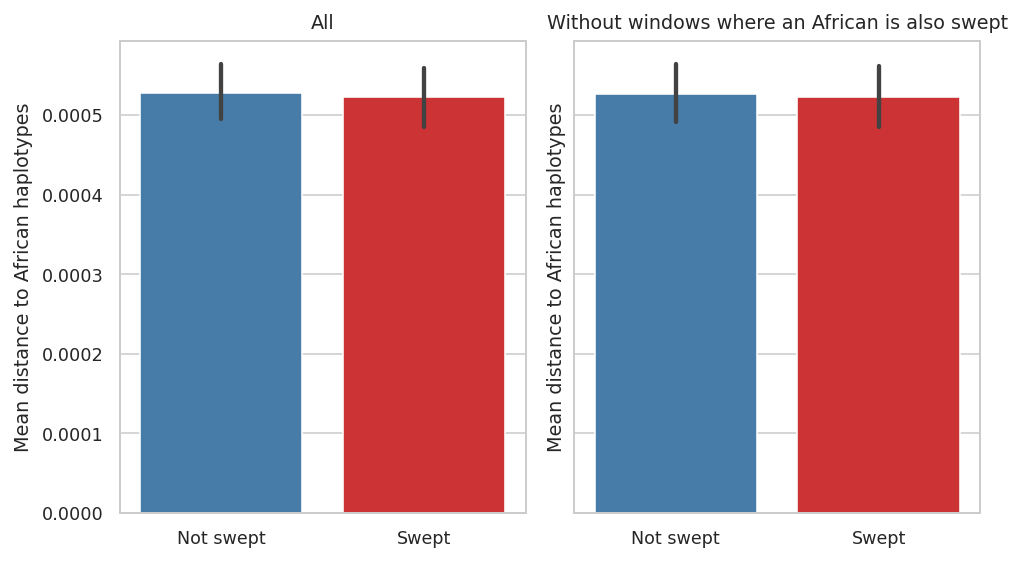

In [24]:
plot_df = (merged_data
      .loc[lambda df: (df.partial_sweep_win == True) & (df.conserv_swept_group != 'ambig')]
      .groupby(['start', 'end', 'swept'])['mean_dist_to_africans']
      .mean()
      .to_frame('mean_afr_dist')
      .reset_index()
      # removing 'ambig' creates windows that does not have both swept and non-swept
      # so we need to filter to get only windows that include both calls:
      .groupby(['start']).filter(lambda df: set(df['swept']) == set([False, True]))
       )

print(plot_df.groupby('swept').mean())
swept = plot_df.sort_values(by='start').loc[lambda df: df['swept']==True, 'mean_afr_dist']
non_swept = plot_df.sort_values(by='start').loc[lambda df: df['swept']==False, 'mean_afr_dist']
pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
reduction = (non_swept.values-swept.values)/non_swept.values
print()
print(len(swept), '100kb chromosome windows')
print('paired t-test pvalue:', pval)
print('mean reduction of swept:', numpy.mean(reduction))

windows_without_swept_afr = (sweep_data
                             .groupby(['start'])
                             .filter(lambda df: ((df.swept == True) & (df.region_1 == 'Africa')).sum() == 0)
                             .loc[:, ['start', 'end']]
                             .drop_duplicates()
                            )

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.0):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), sharey=True)

            g1 = sns.barplot(x="swept", y="mean_afr_dist", 
                             data=plot_df, 
                             ax=ax1, n_boot=1000)

            ax1.set_title('All')
            ax1.set_ylabel('Mean distance to African haplotypes')
            ax1.set_xlabel('')
            ax1.set_xticklabels(['Not swept', 'Swept'])
            
            g2 = sns.barplot(x="swept", y="mean_afr_dist", 
                             data=plot_df.merge(windows_without_swept_afr, on=['start', 'end']),
                             ax=ax2, n_boot=1000)
            ax2.set_title('Without windows where an African is also swept')
            ax2.set_ylabel('Mean distance to African haplotypes')
            ax2.set_xlabel('')
            ax2.set_xticklabels(['Not swept', 'Swept'])
            
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / f'dist_to_afr_{ech_calling_tag}.pdf' ))
            plt.savefig(str(figures_dir / f'dist_to_afr_{ech_calling_tag}.png' ))

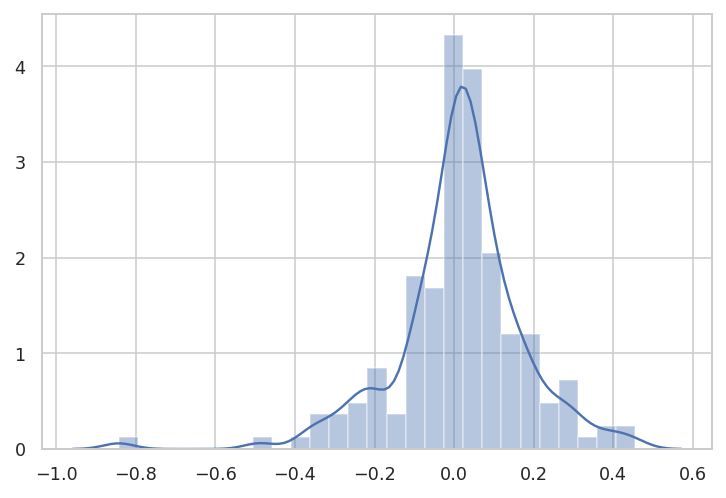

In [25]:
g = sns.distplot(reduction)

All:
Africa               pvalue: nan        corrected pvalue: nan        mean reduction: nan       
WestEurasia          pvalue: nan        corrected pvalue: nan        mean reduction: nan       
SouthAsia            pvalue: nan        corrected pvalue: nan        mean reduction: nan       
CentralAsiaSiberia   pvalue: nan        corrected pvalue: nan        mean reduction: nan       
Oceania              pvalue: nan        corrected pvalue: nan        mean reduction: nan       
EastAsia             pvalue: nan        corrected pvalue: nan        mean reduction: nan       
America              pvalue: nan        corrected pvalue: nan        mean reduction: nan       

Without windows where an African is also swept:
Africa               pvalue: nan        corrected pvalue: nan        mean reduction: nan       
WestEurasia          pvalue: 0.9        corrected pvalue: 5.4        mean reduction: -0.003    
SouthAsia            pvalue: nan        corrected pvalue: nan        mean reductio

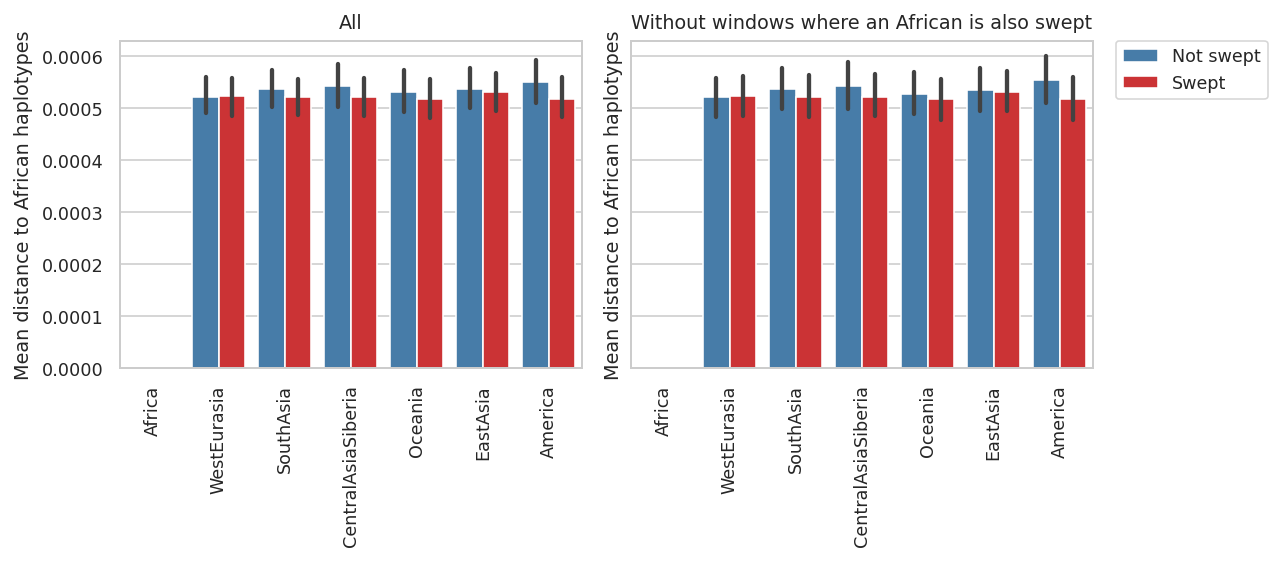

In [26]:
plot_df = (merged_data
      .loc[lambda df: (df.partial_sweep_win == True) & (df.conserv_swept_group != 'ambig')]
      .groupby(['start', 'end', 'swept', 'region_1'])['mean_dist_to_africans']
      .mean()
      .to_frame('mean_afr_dist')
      .reset_index()
      # removing 'ambig' creates windows that does not have both swept and non-swept
      # so we need to filter to get only windows that include both calls:
      .groupby(['start', 'region_1']).filter(lambda df: set(df['swept']) == set([False, True]))
      )

plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

print("All:")
for name, group in plot_df.groupby(['region_1']):
    swept = group.sort_values(by='start').loc[lambda df: df['swept']==True, 'mean_afr_dist']
    non_swept = group.sort_values(by='start').loc[lambda df: df['swept']==False, 'mean_afr_dist']
    pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
    mean_reduction = numpy.mean((non_swept.values-swept.values)/non_swept.values)
    print("{:<20} pvalue: {:<10.2} corrected pvalue: {:<10.2} mean reduction: {:<10.2}".format(name, pval, pval*6, mean_reduction))
print()
print("Without windows where an African is also swept:")
for name, group in plot_df.merge(windows_without_swept_afr, on=['start', 'end']).groupby(['region_1']):
    swept = group.sort_values(by='start').loc[lambda df: df['swept']==True, 'mean_afr_dist']
    non_swept = group.sort_values(by='start').loc[lambda df: df['swept']==False, 'mean_afr_dist']
    pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
    mean_reduction = numpy.mean((non_swept.values-swept.values)/non_swept.values)
    print("{:<20} pvalue: {:<10.2} corrected pvalue: {:<10.2} mean reduction: {:<10.2}".format(name, pval, pval*6, mean_reduction))

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.0):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
            g1 = sns.barplot(x="region_1", y="mean_afr_dist", hue='swept', 
                             data=plot_df, 
                             ax=ax1, n_boot=1000)
            ax1.set_ylabel('Mean distance to African haplotypes')
            ax1.set_xlabel('')
            ax1.set_title('All')
            for item in g1.get_xticklabels():
                item.set_rotation(90)
            ax1.legend_.remove()
            #ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

            g2 = sns.barplot(x="region_1", y="mean_afr_dist", hue='swept', 
                             data=plot_df.merge(windows_without_swept_afr, on=['start', 'end']),
                             ax=ax2, n_boot=1000)
            ax2.set_ylabel('Mean distance to African haplotypes')
            ax2.set_xlabel('')
            ax2.set_title('Without windows where an African is also swept')
            for item in g2.get_xticklabels():
                item.set_rotation(90)
                
                
            ax2.get_legend().set_title('Is swept')
            handles, labels = ax2.get_legend_handles_labels()

            ax2.legend(handles, ['Not swept', 'Swept'],
                     bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     # bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center', ncol=2
                    )    
                
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / f'dist_to_afr_by_region_{ech_calling_tag}.pdf' ))
            plt.savefig(str(figures_dir / f'dist_to_afr_by_region_{ech_calling_tag}.png' ))

## Same but for admix filtered

                 start           end  mean_afr_dist_af
swept_af                                              
False     8.500058e+07  8.510058e+07          0.000526
True      8.500058e+07  8.510058e+07          0.000522

173 100kb chromosome windows
paired t-test pvalue: 0.5673829749462977
mean reduction of swept: 0.007559889215718064


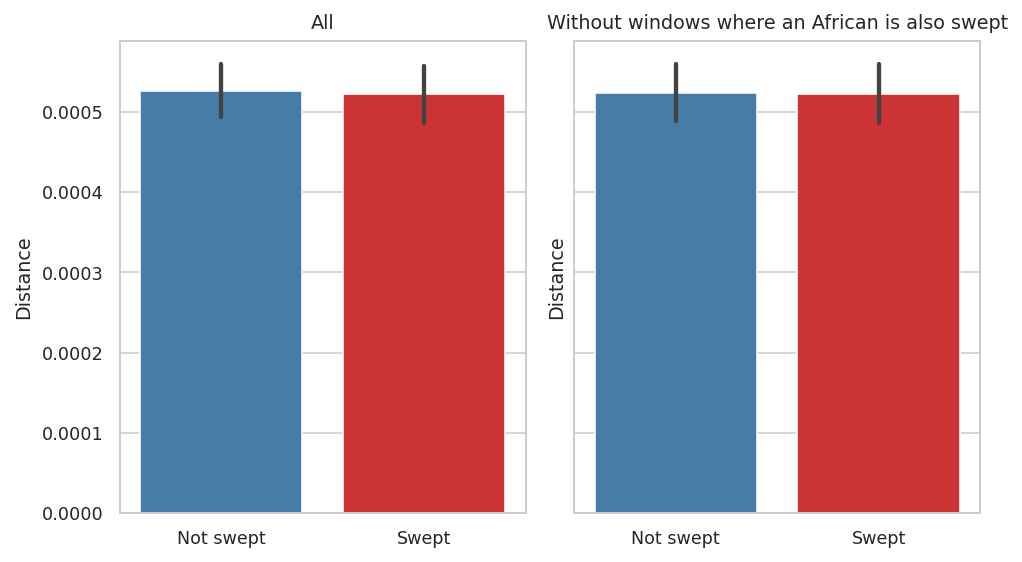

In [27]:
plot_df = (merged_data
#       .loc[lambda df: (df.never_swept == False) & (df.conserv_swept_group != 'ambig')]
      .loc[lambda df: (df.partial_sweep_win_af == True) & (df.conserv_swept_group_af != 'ambig')]
      .groupby(['start', 'end', 'swept_af'])['mean_dist_to_africans_af']
      .mean()
      .to_frame('mean_afr_dist_af')
      .reset_index()
      # removing 'ambig' creates windows that does not have both swept and non-swept
      # so we need to filter to get only windows that include both calls:
      .groupby(['start']).filter(lambda df: set(df['swept_af']) == set([False, True]))
       )

print(plot_df.groupby('swept_af').mean())

swept = plot_df.sort_values(by='start').loc[lambda df: df['swept_af']==True, 'mean_afr_dist_af']
non_swept = plot_df.sort_values(by='start').loc[lambda df: df['swept_af']==False, 'mean_afr_dist_af']
pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
reduction = (non_swept.values-swept.values)/non_swept.values
print()
print(len(swept), '100kb chromosome windows')
print('paired t-test pvalue:', pval)
print('mean reduction of swept:', numpy.mean(reduction))

windows_without_swept_afr = (sweep_data
                             .groupby(['start'])
                             .filter(lambda df: ((df.swept_af == True) & (df.region_1 == 'Africa')).sum() == 0)
                             .loc[:, ['start', 'end']]
                             .drop_duplicates()
                            )

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.0):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), sharey=True)

            g1 = sns.barplot(x="swept_af", y="mean_afr_dist_af", 
                             data=plot_df, 
                             ax=ax1, n_boot=1000)

            ax1.set_title('All')
            ax1.set_ylabel('Distance')
            ax1.set_xlabel('')
            ax1.set_xticklabels(['Not swept', 'Swept'])
            
            g2 = sns.barplot(x="swept_af", y="mean_afr_dist_af", 
                             data=plot_df.merge(windows_without_swept_afr, on=['start', 'end']),
                             ax=ax2, n_boot=1000)
            ax2.set_title('Without windows where an African is also swept')
            ax2.set_ylabel('Distance')
            ax2.set_xlabel('')
            ax2.set_xticklabels(['Not swept', 'Swept'])
            
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / f'dist_to_afr_af_{ech_calling_tag}.pdf' ))
            plt.savefig(str(figures_dir / f'dist_to_afr_af_{ech_calling_tag}.png' ))

All:
Africa               pvalue: nan        corrected pvalue: nan        mean reduction: nan       
WestEurasia          pvalue: nan        corrected pvalue: nan        mean reduction: nan       
SouthAsia            pvalue: nan        corrected pvalue: nan        mean reduction: nan       
CentralAsiaSiberia   pvalue: nan        corrected pvalue: nan        mean reduction: nan       
Oceania              pvalue: nan        corrected pvalue: nan        mean reduction: nan       
EastAsia             pvalue: nan        corrected pvalue: nan        mean reduction: nan       
America              pvalue: nan        corrected pvalue: nan        mean reduction: nan       

Without windows where an African is also swept:
Africa               pvalue: nan        corrected pvalue: nan        mean reduction: nan       
WestEurasia          pvalue: 0.77       corrected pvalue: 4.6        mean reduction: -0.0056   
SouthAsia            pvalue: nan        corrected pvalue: nan        mean reductio

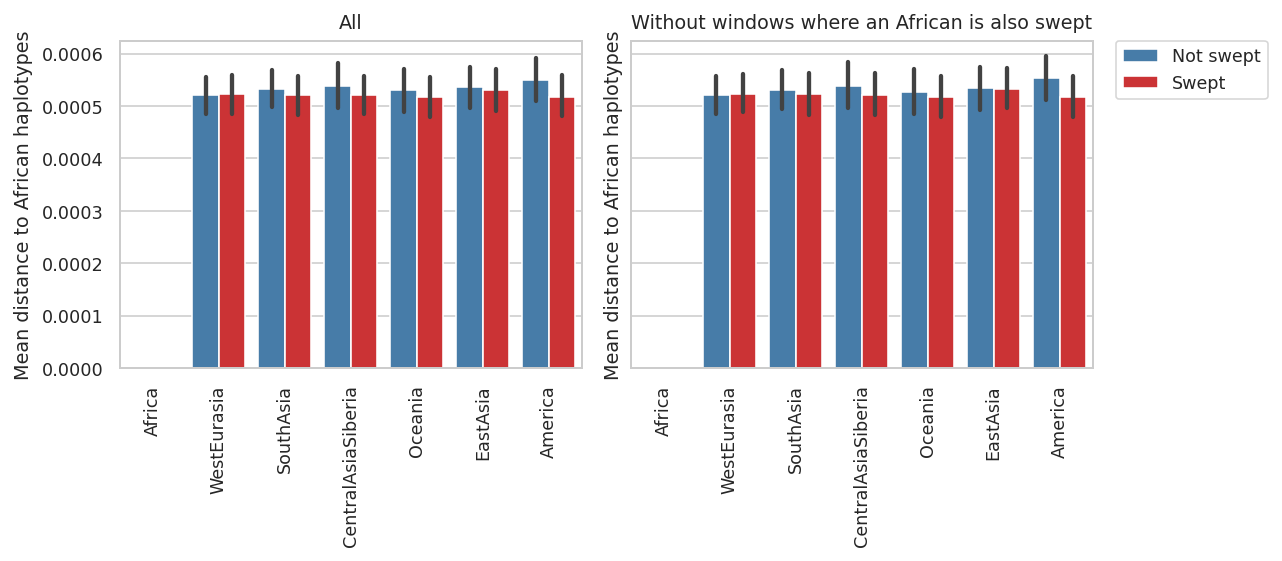

In [28]:
plot_df = (merged_data
      .loc[lambda df: (df.partial_sweep_win_af == True) & (df.conserv_swept_group_af != 'ambig')]
      .groupby(['start', 'end', 'swept_af', 'region_1'])['mean_dist_to_africans_af']
      .mean()
      .to_frame('mean_afr_dist_af')
      .reset_index()
      # removing 'ambig' creates windows that does not have both swept and non-swept
      # so we need to filter to get only windows that include both calls:
      .groupby(['start', 'region_1']).filter(lambda df: set(df['swept_af']) == set([False, True]))
      )

plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

print("All:")
for name, group in plot_df.groupby(['region_1']):
    swept = group.sort_values(by='start').loc[lambda df: df['swept_af']==True, 'mean_afr_dist_af']
    non_swept = group.sort_values(by='start').loc[lambda df: df['swept_af']==False, 'mean_afr_dist_af']
    pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
    mean_reduction = numpy.mean((non_swept.values-swept.values)/non_swept.values)
    print("{:<20} pvalue: {:<10.2} corrected pvalue: {:<10.2} mean reduction: {:<10.2}".format(name, pval, pval*6, mean_reduction))
print()
print("Without windows where an African is also swept:")
for name, group in plot_df.merge(windows_without_swept_afr, on=['start', 'end']).groupby(['region_1']):
    swept = group.sort_values(by='start').loc[lambda df: df['swept_af']==True, 'mean_afr_dist_af']
    non_swept = group.sort_values(by='start').loc[lambda df: df['swept_af']==False, 'mean_afr_dist_af']
    pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
    mean_reduction = numpy.mean((non_swept.values-swept.values)/non_swept.values)
    print("{:<20} pvalue: {:<10.2} corrected pvalue: {:<10.2} mean reduction: {:<10.2}".format(name, pval, pval*6, mean_reduction))
    
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.0):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
            g1 = sns.barplot(x="region_1", y="mean_afr_dist_af", hue='swept_af', 
                             data=plot_df, 
                             ax=ax1, n_boot=1000)
            ax1.set_ylabel('Mean distance to African haplotypes')
            ax1.set_xlabel('')
            ax1.set_title('All')
            for item in g1.get_xticklabels():
                item.set_rotation(90)
            ax1.legend_.remove()
            #ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

            g2 = sns.barplot(x="region_1", y="mean_afr_dist_af", hue='swept_af', 
                             data=plot_df.merge(windows_without_swept_afr, on=['start', 'end']),
                             ax=ax2, n_boot=1000)
            ax2.set_ylabel('Mean distance to African haplotypes')
            ax2.set_xlabel('')
            ax2.set_title('Without windows where an African is also swept')
            for item in g2.get_xticklabels():
                item.set_rotation(90)
                
                
            ax2.get_legend().set_title('Is swept')
            handles, labels = ax2.get_legend_handles_labels()

            ax2.legend(handles, ['Not swept', 'Swept'],
                     bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     # bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center', ncol=2
                    )    
                
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / f'dist_to_afr_by_region_af_{ech_calling_tag}.pdf' ))
            plt.savefig(str(figures_dir / f'dist_to_afr_by_region_af_{ech_calling_tag}.png' ))

# Rest of notebook is not run any more. Lots of it is based on deprecated Basemap